<a href="https://colab.research.google.com/github/tlohde/sense_GEE/blob/main/SENSE_2020_GEE/3_Classification__forProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import earthengine API
import ee
# Authenticate and initialise 
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWjJqet_l2p6cLGKVSwbwty_JpzGFBIu72w3X_0najTMO51PARGFJCY

Successfully saved authorization token.


In [4]:
%matplotlib inline
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams

#!pip install geehydro # Life saver for plotting GEE stuff with Python!
import geehydro
import folium

#import subprocess

import geemap

import wxee
wxee.Initialize()


Number of images in collection:  4

<DatetimeArray>
['2020-05-06 12:10:44.746000', '2020-05-22 12:10:46.579000',
 '2020-06-07 12:10:54.140000', '2020-06-23 12:11:03.228000']
Length: 4, dtype: datetime64[ns]


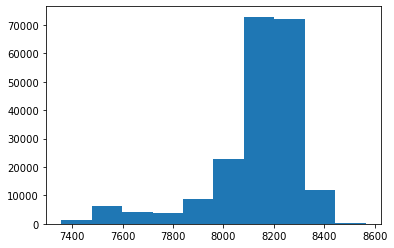

In [169]:
lon = -4.248941
lat = 49.852876

# collection of landsat8 images between dates at point of interest
l8_col = ee.ImageCollection('LANDSAT/LC08/C01/T1').filterBounds(ee.Geometry.Point(lon, lat)).filterDate('2020-05-01','2020-07-31').filter(ee.Filter.eq('WRS_PATH', 204)).filter(ee.Filter.eq('WRS_ROW',25))

# filter(ee.Filter.eq('WRS_PATH', 44))
#   .filter(ee.Filter.eq('WRS_ROW', 34));


# 204, 025 : path, row

# Get the number of images.
count = l8_col.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

# Get the date range of images in the collection.

# range = l8_col.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
#print('Date range: ', str(ee.Date(range.get('min')).getInfo()), str(ee.Date(range.get('max')).getInfo())+'\n')

##### get dates ofeach image

dates = l8_col.getArray("system:time_start")

point = ee.Geometry.Point(-4.248941, 49.852876)

# Get info from the point

info = l8_col.getRegion(point,30).getInfo() # change colelction by series
# print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = pd.array([datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int64))])
#print(time)
# june23 = l8_col.filterDate('2020-06-23').first()
june23 = ee.ImageCollection('LANDSAT/LC08/C01/T1').filterBounds(ee.Geometry.Point(lon, lat)).filterDate('2020-06-21','2020-06-25').first()

june23_rgb = june23.select(['B4','B3','B2'])

# Image(url=june23.getThumbUrl({'min': 0, 'max': 30000, 'bands':['B4','B3','B2'],'dimensions': 512}))

aoi = ee.Geometry.Polygon(
    [[-4.4250233, 50.097365],
      [-4.4332587,50.0885514],
      [-4.4250233,49.9985597],
      [-4.2136499,50.005624],
      [-4.1999243,50.0956024],
      [-4.4250233,50.097365]])

# sample the specific band from image, and convert to 2d array
band_arrs = june23_rgb.sampleRectangle(region = aoi)
#print(band_arrs)
b4 = band_arrs.get('B4')
nparr_b4 = np.array(b4.getInfo())

#print(b4)
# flatten to 1d and get histogram of band

plt.hist(nparr_b4.flatten())

print(time)

## Unsupervised classification

The `ee.Clusterer` package handles unsupervised classification (or clustering) in Earth Engine. More details about each Clusterer are available in the [reference docs in the Code Editor](https://code.earthengine.google.com/#workspace).

Clusterers are used in the same manner as classifiers in Earth Engine. The general workflow for clustering is:

*  Assemble features with numeric properties in which to find clusters.
*   Instantiate a clusterer. Set its parameters if necessary.
*  Train the clusterer using the training data.
* Apply the clusterer to an image or feature collection.
* Label the clusters.


The training data is a `FeatureCollection` with properties that will be input to the clusterer. 

Unlike classifiers, there is no input class value for a Clusterer. 

Like classifiers, the data for the train and apply steps are expected to have the same number of values. When a trained clusterer is applied to an image or table, it assigns an integer cluster ID to each pixel or feature.

These algorithms are currently based on the algorithms with the same name in [Weka](https://www.cs.waikato.ac.nz/ml/weka/).

Here is a simple example of building and using an `ee.Clusterer`:

In [178]:
## band ratio methods
###,

# add ndwi band fucntion
def ndwi_func (img):
#     ndwiOut = img.normalizedDifference(['B3','B5'])
#     water = ndwi.gt(0)
#     img.updateMask(water)    
    return img.addBands(img.normalizedDifference(['B3','B5']).rename('NDWI'))

# add band mask function 
def mask_func (img):
    ndwi = img.select(['NDWI'])
    water = ndwi.gt(0)
    img = img.updateMask(water)
    return img

def br_func (img):   
        
    ndwi = img.normalizedDifference(['B3','B5'])
    water = ndwi.gt(0)
    img = img.updateMask(water)    
    
    b2 = img.select('B2')
    b3 = img.select('B3')
    b4 = img.select('B4')
    b5 = img.select('B5')
       
    
    twobda = b2.divide(b4)
    threebda = (b2.subtract(b4)).divide(b3)
    ndci = (b5.subtract(b4)).divide(b5.add(b4))
    
    return img.addBands(twobda.rename('twobda')).addBands(threebda.rename('threebda')).addBands(ndci.rename('ndci'))

br_col = l8_col.map(br_func).map(a)

# print(br_col.first().bandNames().getInfo())

#### create map
brMap = folium.Map(location = [50.00,-4.2,],zoom_start=6)
# add layers

brMap.addLayer(br_col.first(), {'bands': ['ndci'], 'min':-1, 'max':1}, 'ndci')
# add layer control and view map
folium.LayerControl().add_to(brMap)
brMap


In [204]:
brMap = folium.Map(location = [50.00,-4.2,],zoom_start=6)

for i in arange(len(time)):
    t = time[i]
    tlab = t.strftime('%d%m%Y')
    tplus1 = (t + pd.DateOffset(1)).strftime('%Y-%m-%d')
    tminus1 = (t + pd.DateOffset(-1)).strftime('%Y-%m-%d')
    
    img = br_col.filterDate(tminus1,tplus1).first()
    brMap.addLayer(img, {'bands': ['ndci'], 'min':-1, 'max':1}, tlab)
    
folium.LayerControl().add_to(brMap)
brMap

In [212]:
############# 
# create ndwi function for mapping to image collection #####
#############

# add ndwi band fucntion
def ndwi_func (img):
#     ndwiOut = img.normalizedDifference(['B3','B5'])
#     water = ndwi.gt(0)
#     img.updateMask(water)    
    return img.addBands(img.normalizedDifference(['B3','B5']).rename('NDWI'))

# add band mask function 
def mask_func (img):
    ndwi = img.select(['NDWI'])
    water = ndwi.gt(0)
    img = img.updateMask(water)
    return img

def apply_clust (img):
    clustered = img.cluster(clusterer)
    return img.addBands(clustered.rename('cluster'))
    
# map ndwi and mask function to image collection
ndwi_col = l8_col.map(ndwi_func).map(mask_func).map(apply_clust)

print(ndwi_col.first().bandNames().getInfo())


clMap = folium.Map(location = [50.00,-4.2,],zoom_start=6)

for i in arange(len(time)):
    t = time[i]
    tlab = t.strftime('%d-%m-%Y')
    tplus1 = (t + pd.DateOffset(1)).strftime('%Y-%m-%d')
    tminus1 = (t + pd.DateOffset(-1)).strftime('%Y-%m-%d')
    
    img = ndwi_col.filterDate(tminus1,tplus1).first()
    clust = img.select('cluster')
    clMap.addLayer(clust.randomVisualizer(), {}, tlab)
    clMap.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':20000}, (tlab+'landsat'))
    
folium.LayerControl().add_to(clMap)
clMap




['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA', 'NDWI', 'cluster']


In [108]:
##### create land mask ####

# ndwi 
ndwi = june23.normalizedDifference(['B3', 'B5']) # green and NIR

# Create binary image - water vs. not water
water = ndwi.gt(0) # from McFeeters (1996)

# mask landsat image
june23_masked = june23.updateMask(water)

#### create map
maskMap = folium.Map(location = [50.00,-4.2,],zoom_start=6)
# add layers
maskMap.addLayer(water,{'min':0, 'max':1},'water')
maskMap.addLayer(june23_masked, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':20000}, 'masked landsat image')
# add layer control and view map
folium.LayerControl().add_to(maskMap)
maskMap

In [46]:
# not necessary to define region - as if unpecified defaults to whole image footprint

# Make the training dataset.
training = june23_masked.sample(scale= 30,  numPixels= 5000)

# Instantiate the clusterer and train it.
clusterer = ee.Clusterer.wekaKMeans(3).train(training)

# Cluster the input using the trained clusterer.
result_june23 = june23_masked.cluster(clusterer)
result_may15 = may15.cluster(clusterer)

# Display the clusters with random colors.

resultsMap = folium.Map(location = [50.00,-4.2,],zoom_start=9)
resultsMap.addLayer(result_june23.randomVisualizer(), {}, 'june23_clusters')
resultsMap.addLayer(result_may15.randomVisualizer(), {}, 'may15_clusters')
resultsMap.addLayer(june23, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':20000}, 'june23')
resultsMap.addLayer(may15, {'bands': ['B4', 'B3', 'B2'], 'min':0, 'max':20000}, 'may15')
folium.LayerControl().add_to(resultsMap)
resultsMap
